# Imports

In [2]:
import gensim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from nltk.stem.porter import PorterStemmer
from string import  ascii_lowercase
import nltk #TODO
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import time
from sklearn.metrics import roc_auc_score, roc_curve, auc

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\liort\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
data_path = 'projectData/'
models_path = 'models/'
tb_dir = 'tbs/'

## import word2vec matrix

In [4]:
WORD_2_VEC_PATH = models_path+'word2vec.model'

In [5]:
model = gensim.models.Word2Vec.load(WORD_2_VEC_PATH)
word2vec_matrix = torch.FloatTensor(model.wv.vectors)

# Load Data

In [6]:
raw_data = pd.read_csv(data_path+'dataset_raw.csv')

In [7]:
preprocessed_data =  raw_data['review'].apply(gensim.utils.simple_preprocess)

In [8]:
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))
allowed_symbols = set(l for l in ascii_lowercase)

In [9]:
ascii_lowercase

'abcdefghijklmnopqrstuvwxyz'

In [10]:
def preprocess_sentence(sentence):
    output_sentence = []
    for word in sentence:
        word = word.lower() #lower case the word
        if word not in stop_words:  #ignore stop words
            word = ''.join([i for i in word if i in allowed_symbols]) #remove characters which are not in allowed symbols
            word = stemmer.stem(word) #stemming
            if len(word) >1 : #discard words with length<=1
                output_sentence.append(word)
    return output_sentence
    

In [11]:
preprocessed_data

0        [bromwell, high, is, cartoon, comedy, it, ran,...
1        [homelessness, or, houselessness, as, george, ...
2        [brilliant, over, acting, by, lesley, ann, war...
3        [this, is, easily, the, most, underrated, film...
4        [this, is, not, the, typical, mel, brooks, fil...
                               ...                        
37280    [towards, the, end, of, the, movie, felt, it, ...
37281    [this, is, the, kind, of, movie, that, my, ene...
37282    [saw, descent, last, night, at, the, stockholm...
37283    [some, films, that, you, pick, up, for, pound,...
37284    [this, is, one, of, the, dumbest, films, ve, e...
Name: review, Length: 37285, dtype: object

In [12]:
preprocessed_data = preprocessed_data.apply(preprocess_sentence, convert_dtype=True)

In [ ]:
preprocessed_data

0        [bromwel, high, cartoon, comedi, ran, time, pr...
1        [homeless, houseless, georg, carlin, state, is...
2        [brilliant, act, lesley, ann, warren, best, dr...
3        [easili, underr, film, inn, brook, cannon, sur...
4        [typic, mel, brook, film, much, less, slapstic...
                               ...                        
37280    [toward, end, movi, felt, technic, felt, like,...
37281    [kind, movi, enemi, content, watch, time, bloo...
37282    [saw, descent, last, night, stockholm, film, f...
37283    [film, pick, pound, turn, rather, good, rd, ce...
37284    [one, dumbest, film, ever, seen, rip, nearli, ...
Name: review, Length: 37285, dtype: object

# Train Word2Vec on our New Data

In [ ]:
model = gensim.models.Word2Vec(
    window = 5,
    min_count =5,
    workers= 4
)

In [ ]:
model.build_vocab(preprocessed_data)

In [ ]:
model.epochs = 10

In [ ]:
model.train(preprocessed_data, total_examples=model.corpus_count, epochs = model.epochs)

(41314583, 45543770)

In [ ]:
weights = torch.FloatTensor(model.wv.vectors)

In [ ]:
weights.shape

In [56]:
def check_of_word_in_word2vec(sentence):
    output_sentence = []
    for word in sentence:
        try:
            dummy = model.wv.get_index(word)
            output_sentence.append(word)

        except KeyError:
           continue
    return output_sentence

preprocessed_data = preprocessed_data.apply(check_of_word_in_word2vec)

In [57]:
def tokenize(review):
    return torch.LongTensor([model.wv.get_index(word) for word in review])

In [78]:
X= preprocessed_data.apply(lambda x: tokenize(x))
# review['vector'] 

In [67]:
y = raw_data['label'].tolist()

In [63]:
def pad_collate(batch):
  (xx, yy) = zip(*batch)
  x_lens = [len(x) for x in xx]
  y_lens = [len(y) for y in yy]

  xx_pad = pad_sequence(xx, batch_first=True, padding_value=0)
  yy_pad = pad_sequence(yy, batch_first=True, padding_value=0)

  return xx_pad, yy_pad, x_lens, y_lens

In [81]:
X = pad_sequence(X, batch_first=True, padding_value=0)

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=.25,
                                                    random_state=42)

X_train, y_train = torch.tensor(X_train), torch.tensor(y_train)
X_test, y_test = torch.tensor(X_test), torch.tensor(y_test)

X_train, y_train = torch.tensor(X_train), torch.tensor(y_train)
X_test, y_test = torch.tensor(X_test), torch.tensor(y_test)

C:\Users\liort\AppData\Local\Temp\ipykernel_17056\1581547834.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train, y_train = torch.tensor(X_train), torch.tensor(y_train)
C:\Users\liort\AppData\Local\Temp\ipykernel_17056\1581547834.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test, y_test = torch.tensor(X_test), torch.tensor(y_test)
C:\Users\liort\AppData\Local\Temp\ipykernel_17056\1581547834.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train, y_train = torch.tensor(X_train), torch.tensor(y_train)
C:\Users\liort\Ap

In [84]:
ds_train = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(ds_train, batch_size=32, shuffle=True)

ds_test = torch.utils.data.TensorDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(ds_test, batch_size=32, shuffle=True)

# Define Our Model

## Equations of the LSTM cell:

![lstm.png](lstmeq.jpeg)
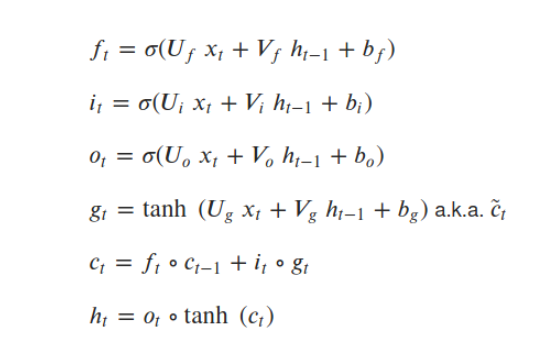

In [118]:
class new_LSTM(nn.Module):
    def __init__(self, input_sz: int, hidden_sz: int, label_sz: int):
        super().__init__()
        self.input_size = input_sz
        self.hidden_size = hidden_sz
        self.label_size = label_sz

        self.W = nn.Parameter(torch.Tensor(input_sz, hidden_sz * 4))
        self.U = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz * 4))
        self.bias = nn.Parameter(torch.Tensor(hidden_sz * 4))
        self.hidden2label = nn.Parameter(torch.Tensor(self.hidden_size, self.label_size))
        
        self.init_weights()
    
    def init_weights(self):
            stdv = 1.0 / math.sqrt(self.hidden_size)
            for weight in self.parameters():
                weight.data.uniform_(-stdv, stdv)
                
    
    def forward(self,
                    x,
                    init_states=None):

            """
            assumes x.shape represents (batch_size, sequence_size, input_size)
            """
            bs, seq_sz, _ = x.size()
            hidden_seq = []

            if init_states is None:
                h_t, c_t = (
                    torch.zeros(bs, self.hidden_size).to(x.device),
                    torch.zeros(bs, self.hidden_size).to(x.device),
                )
            else:
                h_t, c_t = init_states

            #loop over all words in sequence
            HS = self.hidden_size
            for t in range(seq_sz):
                x_t = x[:, t, :]
                gates = x_t @ self.W + h_t @ self.U + self.bias
                
                i_t, f_t, g_t, o_t = (
                    torch.sigmoid(gates[:, :HS]), # input
                    torch.sigmoid(gates[:, HS:HS*2]), # forget
                    torch.tanh(gates[:, HS*2:HS*3]),
                    torch.sigmoid(gates[:, HS*3:]), # output
                )
                
                c_t = f_t * c_t + i_t * g_t
                h_t = o_t * torch.tanh(c_t)
                
                hidden_seq.append(h_t.unsqueeze(0))
                # last word:
                if t==seq_sz-1:
                    y_pred = torch.sigmoid(h_t @ self.hidden2label)
                    
            # convert hidden state list to tensor
            hidden_seq = torch.cat(hidden_seq, dim=0)
            hidden_seq = hidden_seq.transpose(0, 1).contiguous()
            return  y_pred

In [119]:
class Net(nn.Module):
    def __init__(self,input_sz: int, hidden_sz: int, label_sz: int,embedding_weights):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(embedding_weights)
        self.lstm = new_LSTM(input_sz, hidden_sz, label_sz)
    
    def forward(self,x):
        x_embeded = self.embedding(x)
        preds = self.lstm(x_embeded)
        return preds

In [125]:
device = torch.device('cpu')
classifier = Net(100, 50, 1, weights).to(device)
optimizer = optim.Adam(classifier.parameters(), lr=0.01)
criterion = nn.BCELoss()
epochs = 20

# Training Loop

In [129]:
def run_model_loop(train_dataloader,test_dataloader,classifier,epochs,criterion,optimizer,tb_dirname):
    train_loss_list = []
    test_loss_list = []
    train_auc_list=[]
    test_auc_list=[]

    writer = SummaryWriter(log_dir=f'{tb_dir}/{tb_dirname}_{time.time()}')
    i = 0
    for e in range(epochs):
        train_labels_list = []
        train_prediction_list = []
        test_labels_list = []
        test_prediction_list = []
        
        running_loss = 0
        classifier.train()
        
        i+=1
        print(f'epoch {i} started')
        for inputs, labels in train_dataloader:
            labels= labels.to(torch.float32)
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.view(-1,1)
            
            optimizer.zero_grad()
            pred = classifier(inputs)
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()
            running_loss+=loss.item()
            train_prediction_list.extend(pred.flatten().tolist())
            train_labels_list.extend(labels.flatten().tolist())
        epoch_train_loss = running_loss/len(train_dataloader.dataset)
        train_loss_list.append(epoch_train_loss)
        fpr_t, tpr_t, thresholds_t = roc_curve(np.array(train_labels_list), np.array(train_prediction_list))
        train_auc = auc(fpr_t, tpr_t)
        train_auc_list.append(train_auc)    
        
        test_loss = 0
        classifier.eval()
        # we dont need to update weights, so we define no_grad() to save memory
        with torch.no_grad():
            for inputs, labels in test_dataloader:
                labels= labels.to(torch.float32)
                inputs, labels = inputs.to(device), labels.to(device)
                labels = labels.view(-1,1)
                
                test_pred = classifier(inputs)
                test_loss+=criterion(test_pred, labels)
                
                test_prediction_list.extend(test_pred.flatten().tolist())
                test_labels_list.extend(labels.flatten().tolist())
        epoch_test_loss = test_loss/len(test_dataloader.dataset)
        test_loss_list.append(epoch_test_loss)
        fpr_v, tpr_v, thresholds_v = roc_curve(np.array(test_labels_list),np.array(test_prediction_list))
        test_auc = auc(fpr_v, tpr_v)
        test_auc_list.append(test_auc)
        
        #Tensorboard documentation
        #loss
        writer.add_scalar(tag='loss/train', scalar_value=epoch_train_loss, global_step=e)
        writer.add_scalar(tag='loss/test', scalar_value=epoch_test_loss, global_step=e)
        #auc
        writer.add_scalar(tag='auc/train', scalar_value=train_auc, global_step=e)
        writer.add_scalar(tag='auc/test', scalar_value=test_auc, global_step=e)

    return {'train_loss':train_loss_list,
            'train_auc':train_auc_list,
            'test_auc':test_auc_list,
            'test_loss':test_loss_list
            }

In [130]:
lstm_run = run_model_loop(train_loader,test_loader,classifier,epochs,criterion,optimizer,'lr_pytorch')

epoch 1 started
epoch 2 started
epoch 3 started
epoch 4 started
epoch 5 started
epoch 6 started
epoch 7 started
epoch 8 started
epoch 9 started
epoch 10 started
epoch 11 started
epoch 12 started
epoch 13 started
epoch 14 started
epoch 15 started
epoch 16 started
epoch 17 started
epoch 18 started
epoch 19 started
epoch 20 started


# Loss and Auc Plots

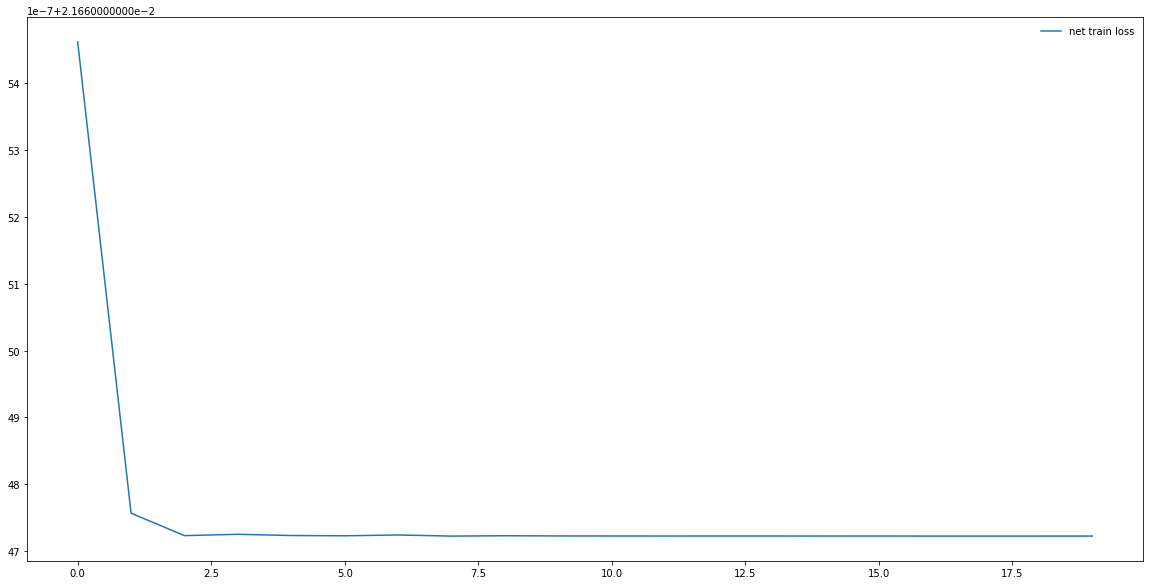

In [137]:
#Loss vs epochs graph 
plt.figure(figsize=(20,10))
plt.plot(lstm_run['train_loss'], label = 'net train loss')
plt.legend(frameon = False)

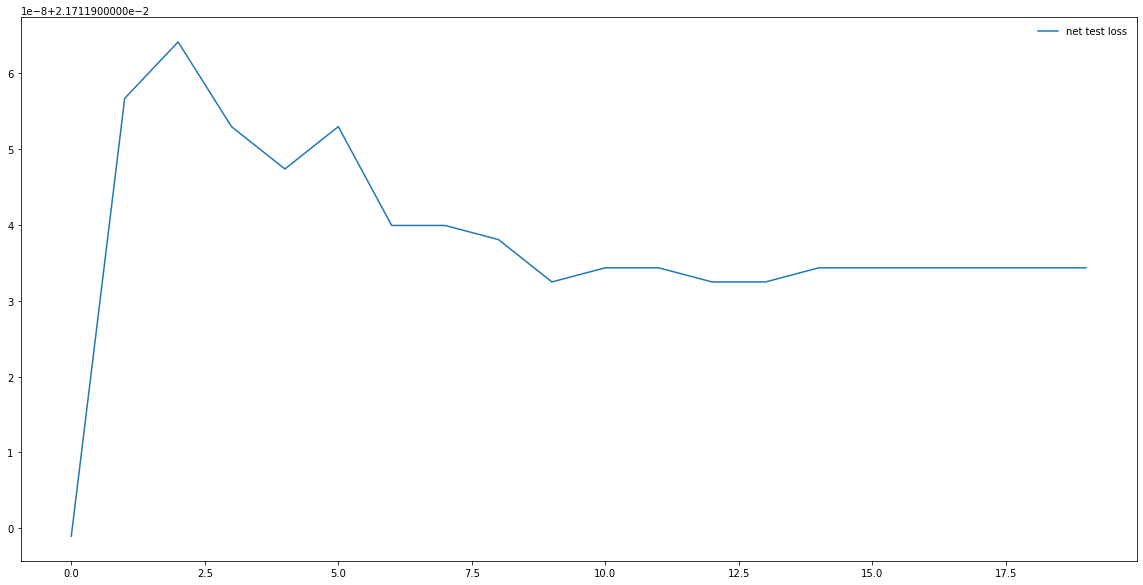

In [142]:
#Loss vs epochs graph 
plt.figure(figsize=(20,10))
plt.plot(lstm_run['test_loss'], label = 'net test loss')
plt.legend(frameon = False)

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(fpr_v, tpr_v, lw=2, alpha=0.3, label='ROC fold')
# ROC GRAPH
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of ' + 'our model'.split("(")[0] + ' model')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.legend(loc = "lower right")
plt.show() 